# Introduction

In this notebook we will use machine learning methods to detect potentially fraudelent transactions in credit card data. This is a classic and important problem in ML given the number of credit card transactions that occur everyday. This is also a difficult problem because a vast majority of credit card transactions are not fradulent. In the Kaggle dataset that we use, only 0.17% of the transactions are fraudelent. This means we have a large degree of class imbalance and we can not rely on a metric like accuracy to judge our ML model. After all, if our model says that every single transaction is not fradulent, it would recieve an accuracy of 99.83%. This sounds great, but clearly its also important we actually catch fraud!

Therefore, instead of measuring the performance of our models by accuracy, we will instead use recall. As a reminder, the recall is defined by:
\begin{align}
\text{recall} &= \frac{\text{TP}}{\text{TP}+\text{FN}}
\end{align}
where TP $=$ True Positives and FN $=$ False Negatives. In our case a fraudelent/non-fradulent transaction corresponds to a positive/negative example, respectively. A higher recall means that we capturing more fraud in our dataset. It is important to emphasize that we will judge the final performance of our models by their recall, but we will not *train* our models to maximize the recall. After all, a model can maximize the recall simply by saying all transactions are fraudelent, but this is not a good solution either.

So how should we train our model on this unbalanced dataset? As usual we train our model minimizing an auxiliary loss function.
To be general, let's write the loss function on our dataset $\mathcal{D}$ as:
\begin{align}
\mathcal{L}(\mathcal{D})=\frac{1}{N}\sum_{i=1}^{N} w_i L(x_i,y_i).
\end{align}
Here $\mathcal{L}(\mathcal{D})$ is the loss as a function of the dataset, $N$ is the size of our dataset, $L(x,y)$ is the loss on a single datapoint $x$ and its associated label $y$, and $w_i$ are sample weights which we are free to specify. 

One option is set all the weights to be equal, e.g. $w_i=1$ for all $i$. If we do this, then there are two simple ways to handle class imbalance, we can either downsample the larger class or upsample the smaller class so that we have a balanced dataset. Clearly neither option is a good choice in our case since the full dataset is severely imbalanced: we have 492 fraudelent transactions and 284315 non-fraudelent transactions. If we downsample the majority class, i.e. only keep 492 non-fradulent transactions, we would be throwing away a lot of information! In order for this kind of downsampling to be useful, we need to ensure that the samples we keep are representative of the full dataset. Alternatively, we could compute the loss $\mathcal{L}_{\mathcal{B}}$ over mini-batches $\mathcal{B}$ which contain all fraudelent transactions in our training set and a random sample of the non-fraudelent transactions. Another option to upsample, or oversample, the fradulent transactions so that our model sees the same number of fradulent transactions as non-fraudelent ones. However, this would lead to our dataset effectively doubling in size!

Instead, we will deal with this imbalance by changing the weights. We assign non-fraudelent and fraudelent transactions the labels $y=0$ and $y=1$ respectively. We also define $N_a$ to be the number of transactions with label $y=a$, i.e. $N_0$ and $N_1$ are the total number of non-fraudelent and fraudelent transactions, respectively. We then define the weights to be:
\begin{align}
w_i = \frac{1}{2N_{y_i}}.
\end{align}
We arrived at these weights by imposing the following two conditions:
\begin{align}
N_{0}w_{0} - N_1 w_1&=0,
\\
N_{0}w_0+N_1w_1&=1.
\end{align}
The first condition guarantees that both classes have effectively equal weight by weighting individual fraudelent transactions more than non-fraudelent ones. The second condition is a normalization condition so that the sum over all the weights adds up to one.

Note that our choice of the weights is certainly not unique. If we assign even higher weights to fraudelent transactions we can ensure our model has a higher recall, at the price of having more false positives. In addition, our normalization condition is completely arbitrary and one may want to replace the second condition by $N_{0}w_0+N_1w_1=C$, where $C$ is some arbitrary constant, if our optimization algorithm depends on the scale of the weights.

The remainder of the notebook is organized as follows:

* **Dependencies**: Here we install and import various useful libraries which will be used to organize, plot and fit our dataset. We also define a useful helper function to plot the distribution of our features.

* **Process Data**: In this section we download the dataset and perform exploratory data analysis. In particular, we plot the distribution of our data, see how the features within a given class are correlated, and use dimensionality reduction to visualize our data.

* **Full Training**: This section contains most of our code. In the subsection **Sklearn** we import various ML models from Sci-kit learn and train them on the credit card dataset. We fit our models either by minimizing the loss where all the weights are equal or by choosing the weights so that the fraudelent and non-fraudelent transactions are effectively weighted equally. We find that weighting the data generally leads to better performance. In the subsections **XGBoost** and **LGBM** we repeat this analysis, but this time using XGBoost models and lightly boosted gradient machines (LGBM), respectively. Once again, we find that reweighting the samples leads to better performance.

In order to run this notebook, one needs to download the Kaggle credit card dataset, which can be found <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">here</a>. One comment about this dataset is that most of the features have been anonymized due to confidentiality issues, so it is difficult to determine if any of our data is perhaps mislabelled. We will assume the data is clean and the labels are correct, but it is always important to keep in mind that there can be error or noise in both our features and labels! 

Finally, in the future we will add additional results from hyperparameter tuning.

# Dependencies

Below we import a variety of useful libraries and functions from the Pandas, seaborn, sklearn, xgboost and lightgbm libraries.

In [30]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     cross_val_score,
                                     GridSearchCV,
                                    RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier,
                              ExtraTreesClassifier)

from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             accuracy_score,
                            accuracy_score,
                            recall_score)

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from tqdm import tqdm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.manifold import TSNE
import time
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import recall_score
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from collections import defaultdict

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

The plot distribution function will be used to visualize the distribution of our features for each class individually. This type of plot is useful to visually see which features will be most important in distinguishing them.

In [2]:
def plot_distribution(data, data_select):
    """
    Plots the distribution of a select number of features for each class individually.
    
    Inputs:
    -------
    - data (Pandas DataFrame): Dataset we want to visualize. Can in principle include class labels.
    - col (str): Column name, or feature, whose distribution we will visualize.
    
    Output:
    -------
    None. Produces plot in notebook.
    """
    
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(data, hue = 'Class',aspect = 2.5, palette ={0 : 'blue', 1 :'red'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(data[data_select].min(), data[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

# Process Data

## Download and Split Data

We start by downloading our data, which we have saved to our local data folder. The filepath should be changed to wherever you have saved the data. 

In [3]:
dataset = read_csv('./data/creditcard.csv')

We see that there are a total of 284807 data-points and 31 features.

In [4]:
# shape
dataset.shape

(284807, 31)

Here we see that our dataset is severely imbalanced, there hare almost 300k transactions which are not fraudelent, but only 492 fraudelent ones.

In [5]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


In [6]:
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Below we see that all of our features are numeric, and specifically of type float64. We have explicitly excluded the 'Class' label, which is an integer.

In [7]:
set(dataset[[col for col in dataset.columns if col!='Class']].dtypes.to_list())

{dtype('float64')}

Here we use the pandas describe method to get a sense of how our features are distributed. Although this does provide useful information, we will see that producing plots is much more useful.

In [8]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Below we perform a 80%-20% stratified split on our dataset between the training and test set. We stratify by the class label so that both the training and test set have roughly the fraction of fraudelent vs non-fraudelent transactions. If we did not perform a stratified split there is a good chance our test set would contain an even more imbalanced class distribution.

In [9]:
df_train, df_test = train_test_split(dataset,
                                     test_size=0.2,
                                     stratify = dataset.Class)

#num_folds = 10
#
#scaler = StandardScaler().fit(
#    df_train['Amount'].values.reshape(-1,1))
#
#df_train['nAmount'] = scaler.transform(
#    df_train['Amount'].values.reshape(-1,1))
#
#df_test['nAmount'] = scaler.transform(
#    df_test['Amount'].values.reshape(-1,1))
#

df_train.drop(columns=['Time'],inplace=True)
df_test.drop(columns=['Time'],inplace=True)

Y_train, Y_test = df_train["Class"], df_test["Class"]

X_train = df_train.drop(columns = ["Class"])
X_test = df_test.drop(columns = ["Class"])

## EDA

Below we plot the distribution of each feature for each class individually. The distribution of the features for the non-fraudelent transactions are shown in blue while the fraudelent transactions are shown in red. We observe that for some features there is a clear difference between the two plots, for example for feature V4 we observe the blue curve peaks at a higher value and is centered at zero, while the red curve is centered around closer to 3-4. On the other hand, for some features, like feature V15, there is no clear way to distinguish the two distributions.

These types of plots give a useful visualization of what features may be the most important for our classification algorithm. However, we should not rely on these plots alone since they don't take into account the effects of feature interactions.

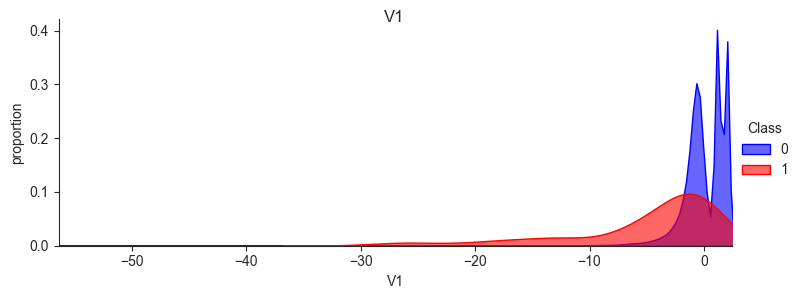

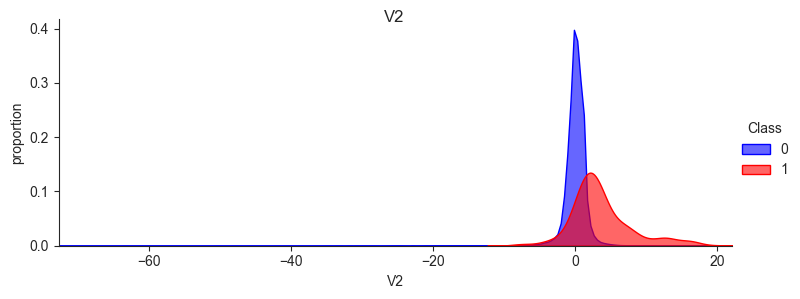

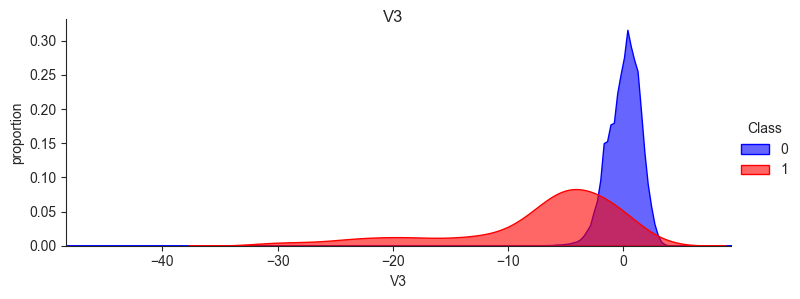

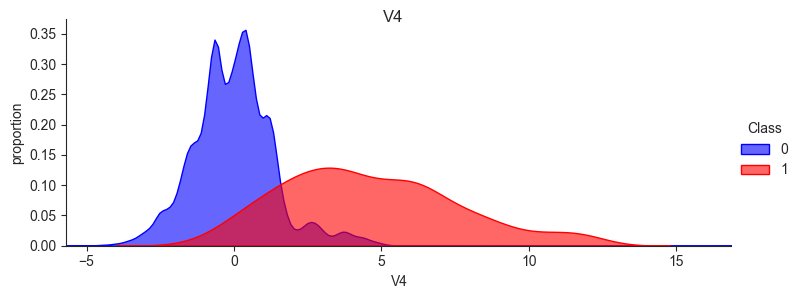

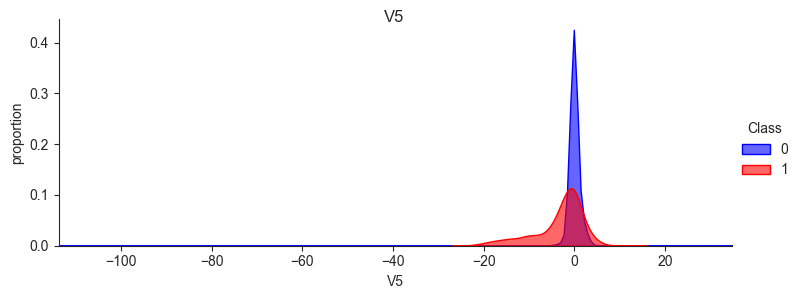

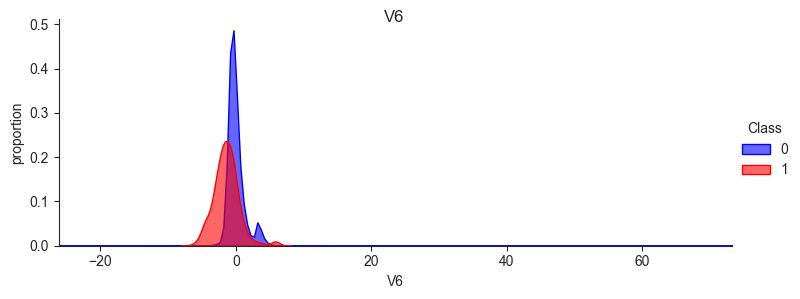

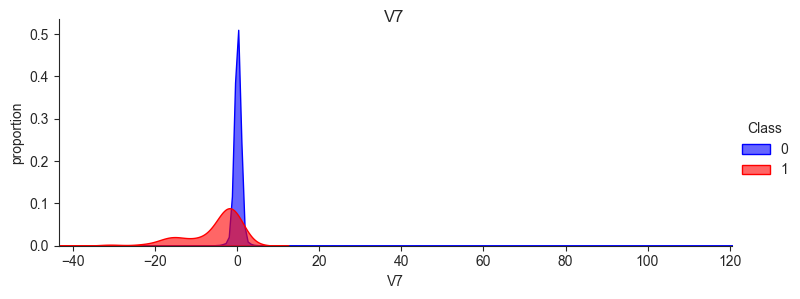

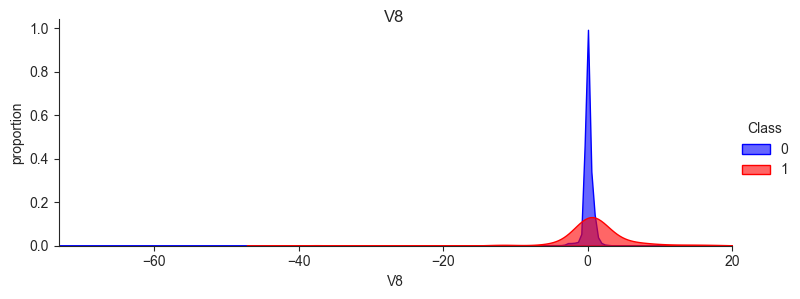

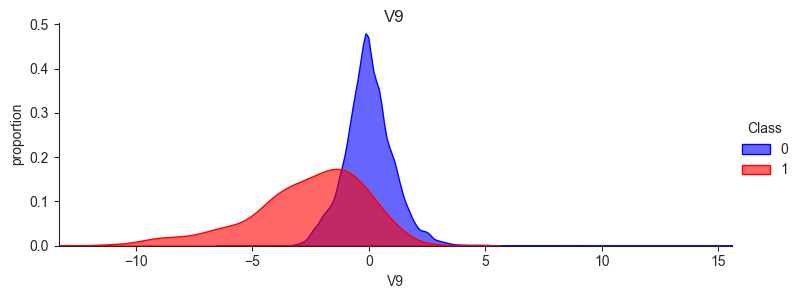

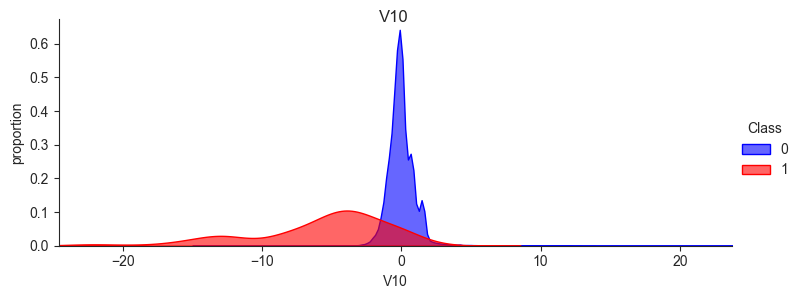

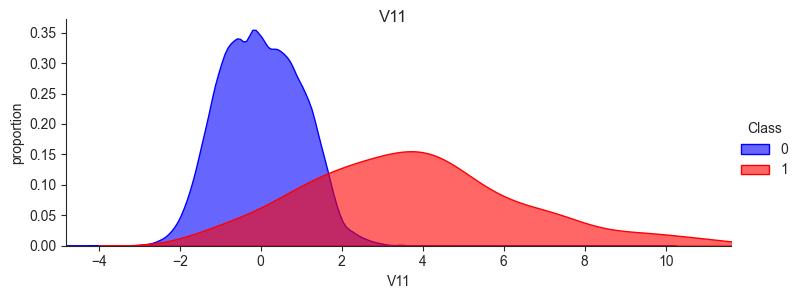

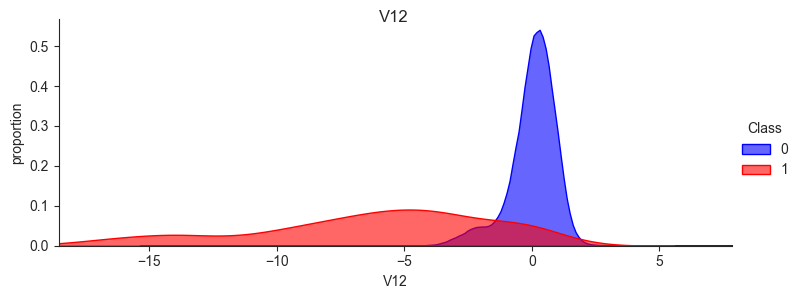

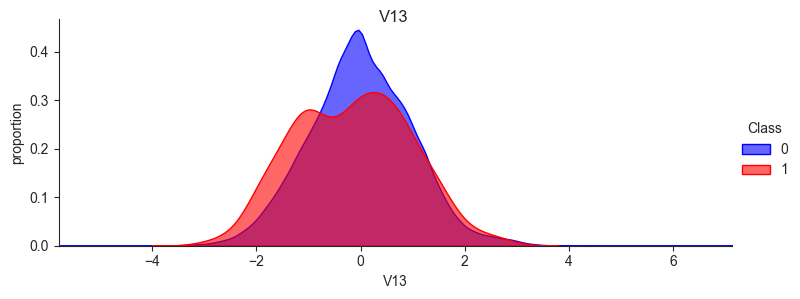

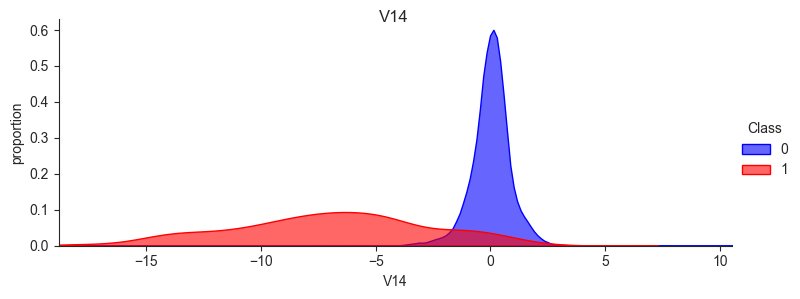

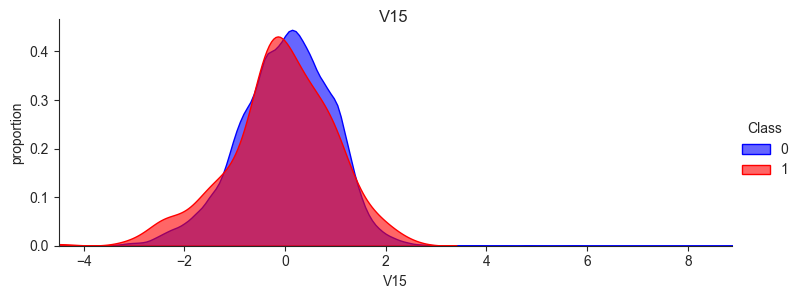

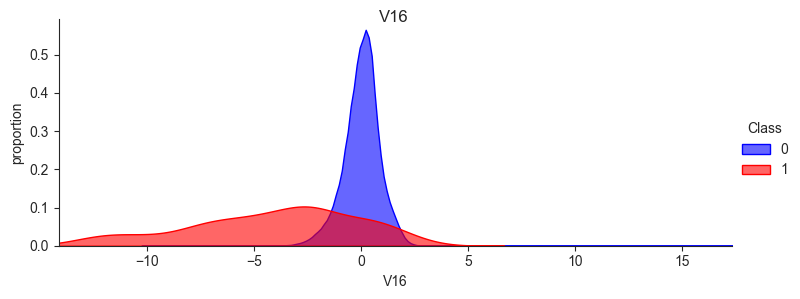

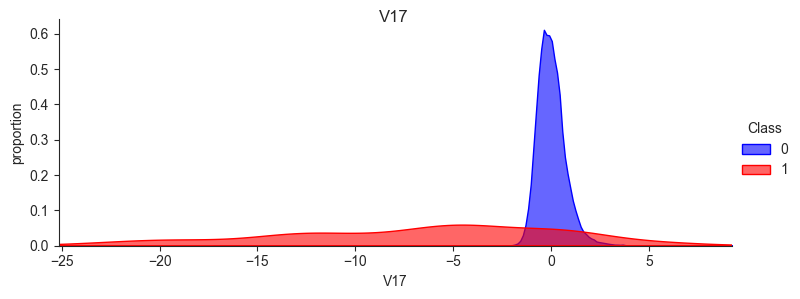

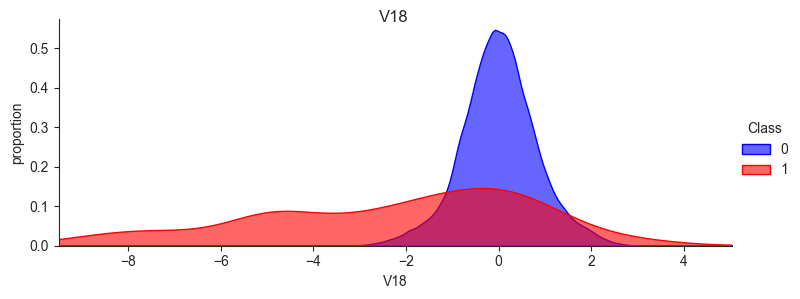

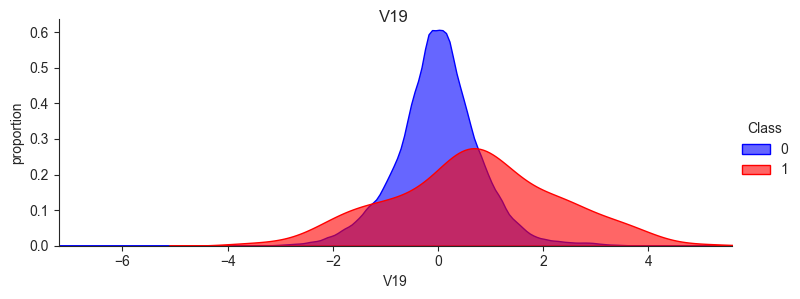

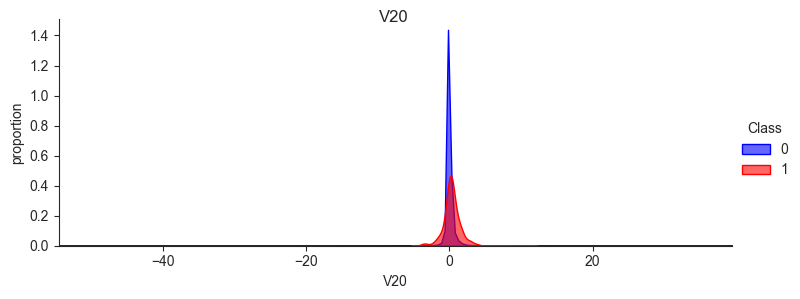

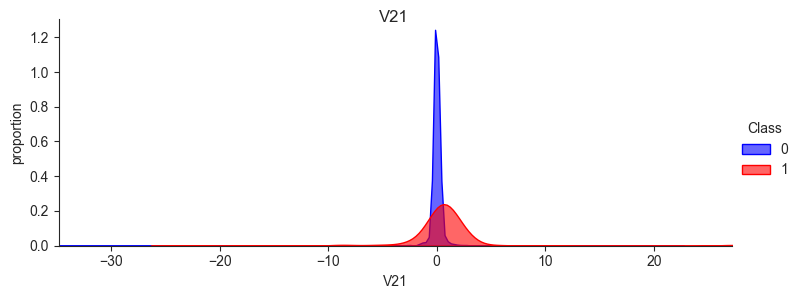

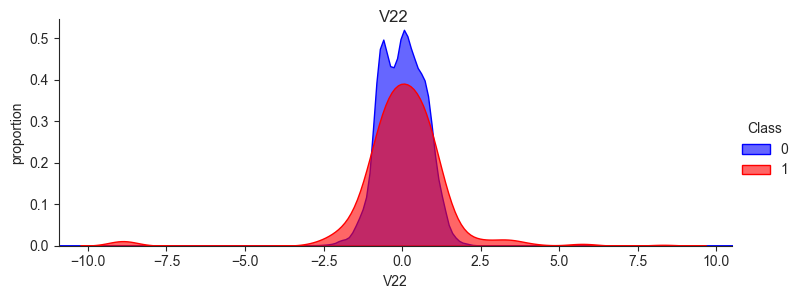

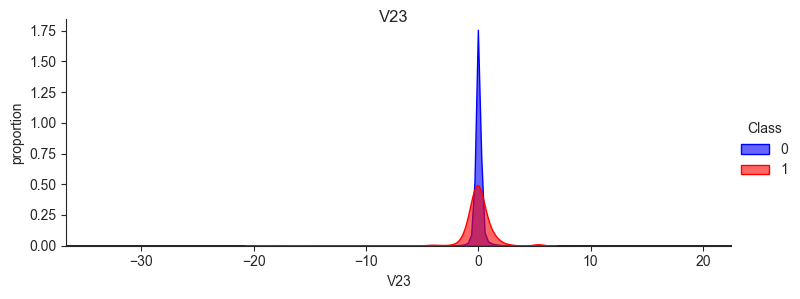

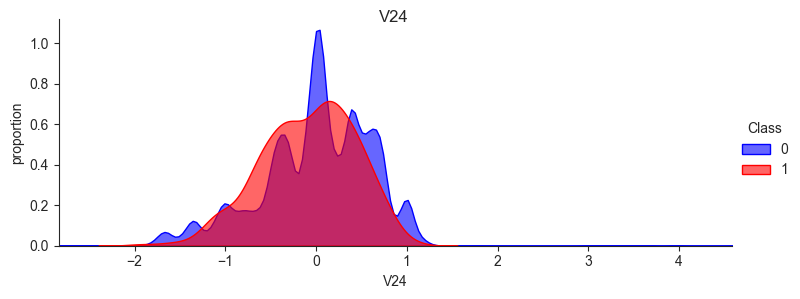

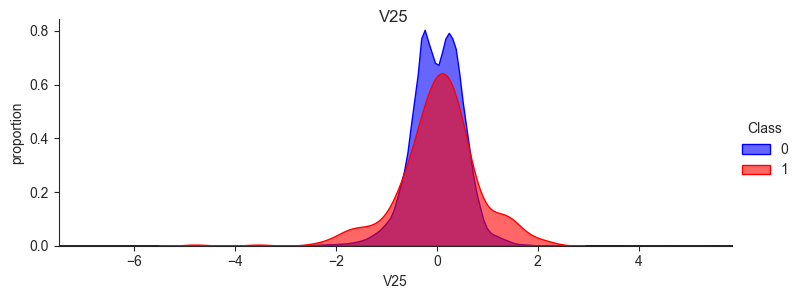

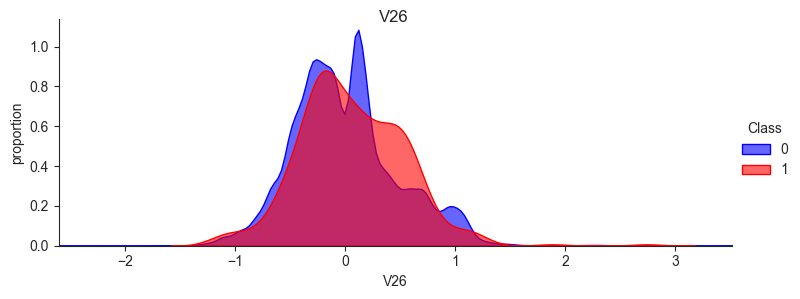

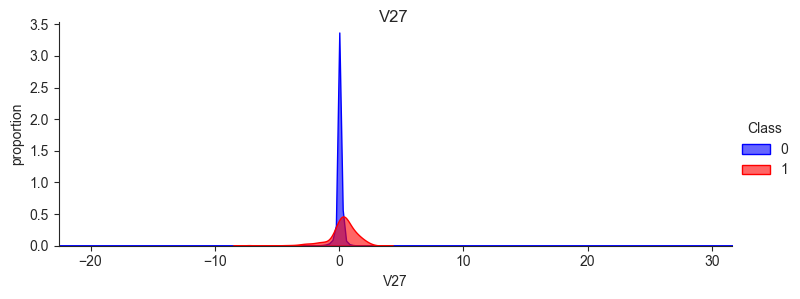

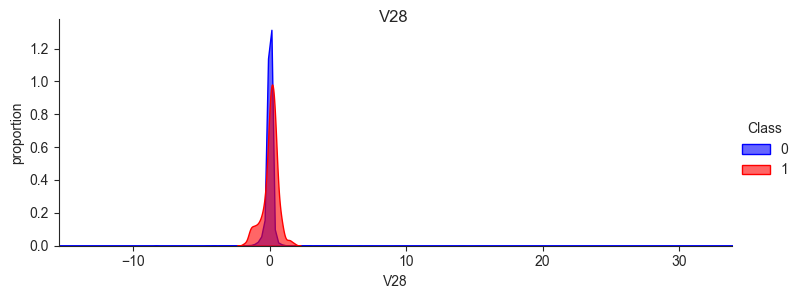

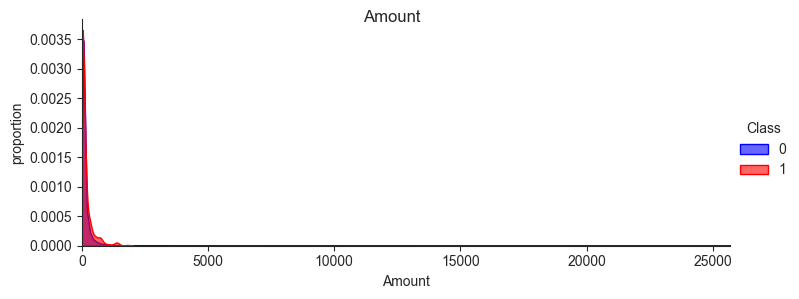

In [10]:
for col in df_train.columns:
    if col == 'Class':
        continue
    plot_distribution(df_train,col)

Below, we use a heatmap to plot the correlations between the different features. It should not be surprising that features V1-V14 are all uncorrelated since they were found by performing PCA on the original (anonymized) features. To learn about feature interactions, we will construct more plots below where we study correlations on subsets of the data.

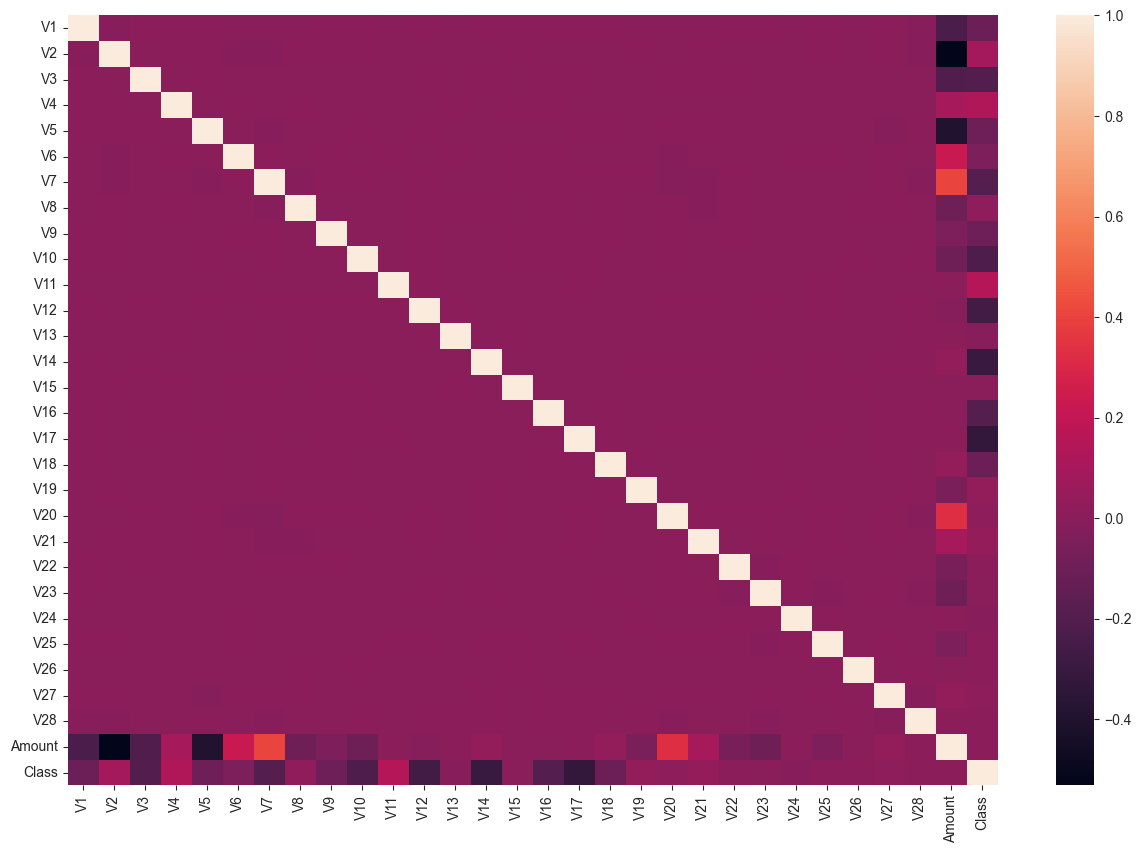

In [11]:
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_train.corr());
plt.show()

In the plots below we again make a heatmap of the correlation matrix, but now we make separate heatmaps for fraudelent vs non-fraudelent transactions. We observe these heatmaps contain a lot more information! In particular, we observe that for normal transactions that most of the features are not very correlated with each other, while for fraudelent transactions there can be a very strong correlations between different features. This is a signal that to get the possible results we likely need to use non-linear ML models which can take into account feature interactions and/or trying to perform feature engineering by hand.

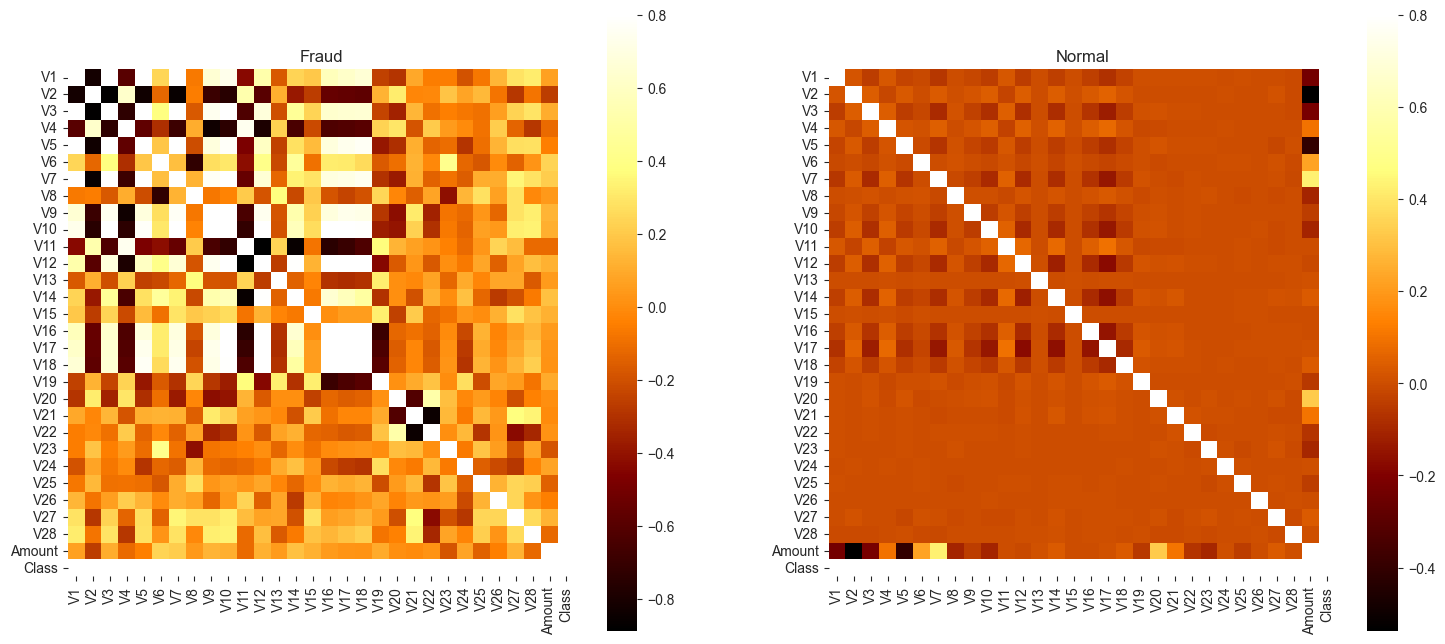

In [12]:
# Correlation matrix
f, (ax1, ax2) = plt.subplots(1,2,figsize =(18, 8))
corr = df_train.corr()
sns.heatmap((df_train.loc[df_train['Class']==1]).corr(),
            vmax = .8, square=True,
            ax = ax1,
            cmap = 'afmhot'
           );

ax1.set_title('Fraud');
sns.heatmap((df_train.loc[df_train['Class'] ==0]).corr(),
            vmax = .8, square=True,
            ax = ax2,
            cmap = 'afmhot'
           );
ax2.set_title('Normal');
plt.show()

To visualize the data, it also helpful to perform dimensional reduction to two-dimensions and view the data-points directly. In particular, we will use t-SNE, PCA, and truncated SVD to perform dimensional reduction. Since this dimensional reduction can take a very long time we will downsample the non-fraudelent class so that we have the same number of fraudelent and normal transactions.

In [17]:
df_fraud = df_train[df_train['Class']==1]
df_non_fraud_samp = df_train[df_train['Class']==0].sample(n=len(df_fraud))
df_downsampled = pd.concat([df_fraud,df_non_fraud_samp]).sample(frac=1)

In [18]:
Y_downsampled = df_downsampled['Class']
X_downsampled = df_downsampled.drop(columns=['Class','Amount'])

In [19]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_downsampled.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_downsampled.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2,
                             algorithm='randomized',
                             random_state=42).fit_transform(X_downsampled.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.4 s
PCA took 0.021 s
Truncated SVD took 0.014 s


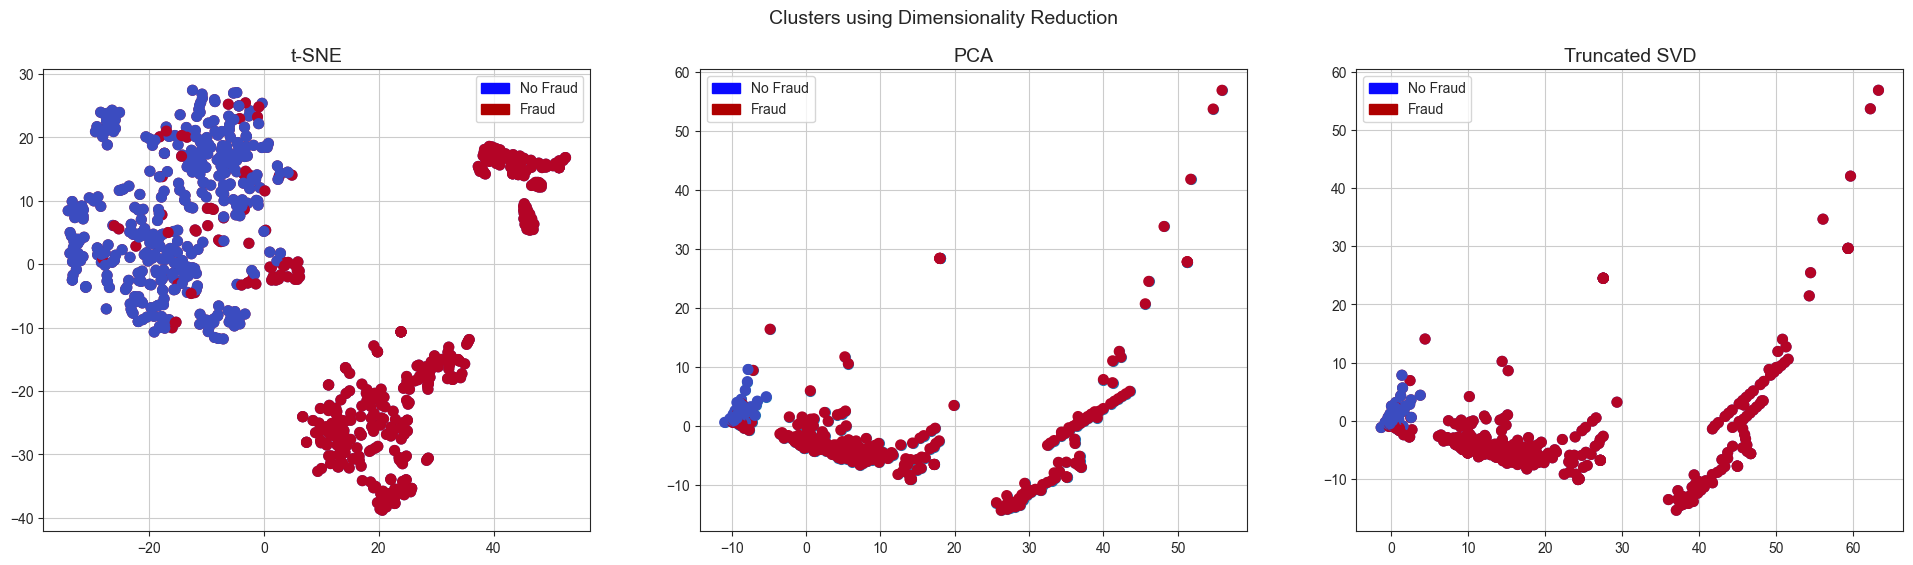

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_downsampled == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_downsampled == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(Y_downsampled == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(Y_downsampled == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(Y_downsampled == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Full Training

## Sklearn

### No Weighting

In [ ]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))

# # Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

In [ ]:
results_unbal = {}
scoring = 'recall'
seed = 123
num_folds = 10

for name, model in tqdm(models):
    
    steps = []
    steps.append(('scaler',StandardScaler()))
    steps.append(('model',model))
    pipeline = Pipeline(steps = steps)
     
    
    kfold = StratifiedShuffleSplit(n_splits=num_folds,
                                   random_state=seed)

    cv_results = cross_val_score(pipeline,
                                 X_train,
                                 Y_train,
                                 cv=kfold,
                                 scoring=scoring)
    results_unbal[name] = cv_results

    print(f'\n{name}: {round(cv_results.mean(),3)} ({round(cv_results.std(),3)})')

 10%|████▍                                       | 1/10 [00:06<01:00,  6.77s/it]


LR: 0.61 (0.057)


 20%|████████▊                                   | 2/10 [00:11<00:45,  5.65s/it]


LDA: 0.764 (0.096)


 30%|█████████████▏                              | 3/10 [02:13<06:50, 58.62s/it]


CART: 0.759 (0.074)


 40%|█████████████████▌                          | 4/10 [02:14<03:36, 36.00s/it]


NB: 0.826 (0.044)


 50%|█████████████████████▌                     | 5/10 [23:30<40:15, 483.19s/it]


SVM: 0.631 (0.076)


 60%|█████████████████████████▊                 | 6/10 [31:55<32:41, 490.45s/it]


NN: 0.79 (0.068)


 70%|██████████████████████████████             | 7/10 [52:21<36:33, 731.01s/it]


RF: 0.774 (0.089)


 80%|██████████████████████████████████▍        | 8/10 [53:37<17:24, 522.46s/it]


ET: 0.779 (0.069)


 90%|██████████████████████████████████████▋    | 9/10 [59:41<07:52, 472.95s/it]


AB: 0.695 (0.076)


100%|████████████████████████████████████████| 10/10 [1:33:36<00:00, 561.60s/it]


GBM: 0.403 (0.243)


In [61]:
pd.DataFrame(results_unbal).to_csv('./results/results_unbal.csv')

In [60]:
pd.DataFrame(results_unbal).mean()

LR      0.610256
LDA     0.764103
CART    0.758974
NB      0.825641
SVM     0.630769
NN      0.789744
RF      0.774359
ET      0.779487
AB      0.694872
GBM     0.402564
dtype: float64

### Reweighting

In [13]:
wghts = np.zeros(Y_train.shape[0])
wghts[Y_train==1] = 1/788.
wghts[Y_train==0] = 1/454902.

In [14]:
models = []

models.append(('LR', LogisticRegression()))

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network

# # Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

In [51]:
results_bal = defaultdict(list)
scoring = 'recall'
seed = 123

for name, model in tqdm(models):
    #print(name)
    sss = StratifiedShuffleSplit(n_splits = 10,
                                 test_size=0.2,
                                 random_state=seed)

    splits = sss.split(X_train,Y_train)
    
    for i, idxs in enumerate(splits):

        scaler = StandardScaler()
        
        X_train_cv = scaler.fit_transform(X_train.iloc[idxs[0]])
        Y_train_cv = Y_train.iloc[idxs[0]]

        X_test_cv = scaler.transform(X_train.iloc[idxs[1]])
        Y_test_cv = Y_train.iloc[idxs[1]]

        weights_cv = np.zeros(Y_train_cv.shape)
        weights_cv[Y_train_cv == 0] = 1/(2*(Y_train==0).sum())
        weights_cv[Y_train_cv == 1] = 1/(2*(Y_train==1).sum())

        clf = model.fit(X = X_train_cv,
                        y = Y_train_cv,
                        sample_weight = weights_cv)

        Y_pred = clf.predict(X_test_cv)
        
        results_bal[name].append(recall_score(Y_test_cv,Y_pred))
    
    print(f'\n{name}: {round(np.mean(results_bal[name]),3)} ({round(np.std(results_bal[name]),3)})')

 14%|██████▍                                      | 1/7 [00:01<00:10,  1.82s/it]


LR: 0.835 (0.03)


 29%|████████████▊                                | 2/7 [00:49<02:22, 28.56s/it]


CART: 0.708 (0.047)


 43%|███████████████████▎                         | 3/7 [00:50<01:04, 16.07s/it]


NB: 0.867 (0.03)


 57%|█████████████████████████▏                  | 4/7 [10:23<11:48, 236.00s/it]


RF: 0.753 (0.031)


 71%|███████████████████████████████▍            | 5/7 [18:24<10:48, 324.45s/it]


ET: 0.776 (0.042)


 86%|█████████████████████████████████████▋      | 6/7 [23:49<05:24, 324.70s/it]


AB: 0.885 (0.022)


100%|██████████████████████████████████████████| 7/7 [1:09:06<00:00, 592.42s/it]


GBM: 0.887 (0.024)


In [59]:
pd.DataFrame(results_bal).to_csv('./results/results_bal.csv')

In [67]:
pd.DataFrame(results_bal).agg([np.mean,np.std]).T

,mean,std
LR,0.835443,0.032134
CART,0.707595,0.049369
NB,0.867089,0.031716
RF,0.753165,0.032819
ET,0.775949,0.043870
AB,0.884810,0.023455
GBM,0.887342,0.024927


## XGBoost

### No Weighting

In [41]:
print(1/788.)
print(1/454902.)

0.0012690355329949238
2.198275672562442e-06


In [ ]:
print(1/(2*(Y_train==1).sum()))
print(1/(2*(Y_train==0).sum()))

0.0012690355329949238
2.198275672562442e-06


In [54]:
weights_cv

array([2.19827567e-06, 2.19827567e-06, 2.19827567e-06, ...,
       2.19827567e-06, 2.19827567e-06, 2.19827567e-06])

In [56]:
sss = StratifiedShuffleSplit(n_splits = 10,
                       test_size=0.2)
splits = sss.split(X_train,Y_train)

result_xgb_unbal = []

for i, idxs in tqdm(enumerate(splits)):
    print(f'Working on split {i}')
    
    X_train_cv = X_train.iloc[idxs[0]]
    Y_train_cv = Y_train.iloc[idxs[0]]
    
    X_test_cv = X_train.iloc[idxs[1]]
    Y_test_cv = Y_train.iloc[idxs[1]]
    
    xgb_clf = XGBClassifier().fit(X=X_train_cv,y=Y_train_cv)
    
    Y_pred = xgb_clf.predict(X_test_cv)
    
    result_xgb_unbal.append(recall_score(Y_test_cv,Y_pred))

0it [00:00, ?it/s]

Working on split 0


1it [00:24, 24.39s/it]

Working on split 1


2it [00:51, 25.78s/it]

Working on split 2


3it [01:15, 25.28s/it]

Working on split 3


4it [01:38, 24.34s/it]

Working on split 4


5it [02:00, 23.45s/it]

Working on split 5


6it [02:24, 23.67s/it]

Working on split 6


7it [02:49, 23.98s/it]

Working on split 7


8it [03:12, 23.73s/it]

Working on split 8


9it [03:35, 23.57s/it]

Working on split 9


10it [04:00, 24.01s/it]


In [57]:
df_xgb_unbal = pd.DataFrame(result_xgb_unbal,index=np.arange(1,11),columns=['recall'])
df_xgb_unbal.index.name = 'split'
df_xgb_unbal.to_csv('./results/xgb_results_unbal')

In [58]:
df_xgb_unbal

,recall
split,
1,0.810127
2,0.810127
3,0.734177
4,0.772152
5,0.708861
6,0.759494
7,0.797468
8,0.721519
9,0.746835


In [60]:
df_xgb_unbal.mean()

recall    0.762025
dtype: float64

### Reweighting

In [78]:
sss = StratifiedShuffleSplit(n_splits = 10,
                       test_size=0.2)
splits = sss.split(X_train,Y_train)

result_xgb_bal_1 = []
result_xgb_bal_2 = []

for i, idxs in tqdm(enumerate(splits)):
    print(f'Working on split {i}')
    
    X_train_cv = X_train.iloc[idxs[0]]
    Y_train_cv = Y_train.iloc[idxs[0]]
    
    X_test_cv = X_train.iloc[idxs[1]]
    Y_test_cv = Y_train.iloc[idxs[1]]
    
    weights_cv = np.zeros(Y_train_cv.shape)
    weights_cv[Y_train_cv == 0] = 1/(2*(Y_train==0).sum())
    weights_cv[Y_train_cv == 1] = 1/(2*(Y_train==1).sum())
    
    weights_cv_1 = weights_cv/(1/(2*(Y_train==0).sum()))
    xgb_clf = XGBClassifier().fit(X = X_train_cv,
                                  y = Y_train_cv,
                                  sample_weight = weights_cv_1)
    
    Y_pred_1 = xgb_clf.predict(X_test_cv)
    result_xgb_bal_1.append(recall_score(Y_test_cv,Y_pred_1))
    
    weights_cv_2 = weights_cv/(1/(2*(Y_train==1).sum()))
    xgb_clf = XGBClassifier().fit(X = X_train_cv,
                                  y = Y_train_cv,
                                  sample_weight = weights_cv_2)
    
    Y_pred_2 = xgb_clf.predict(X_test_cv)
    result_xgb_bal_2.append(recall_score(Y_test_cv,Y_pred_2))

0it [00:00, ?it/s]

Working on split 0


1it [00:40, 40.01s/it]

Working on split 1


2it [01:20, 40.16s/it]

Working on split 2


3it [02:05, 42.59s/it]

Working on split 3


4it [02:48, 42.56s/it]

Working on split 4


5it [03:30, 42.61s/it]

Working on split 5


6it [04:12, 42.38s/it]

Working on split 6


7it [04:58, 43.45s/it]

Working on split 7


8it [05:48, 45.55s/it]

Working on split 8


9it [06:35, 45.91s/it]

Working on split 9


10it [07:26, 44.66s/it]


In [81]:
print(np.mean(result_xgb_bal_1))
np.mean(result_xgb_bal_2)

0.8177215189873419


0.8810126582278481

In [82]:
df_xgb_bal_1 = pd.DataFrame(result_xgb_bal_1,index=np.arange(1,11),columns=['recall'])
df_xgb_bal_1.index.name = 'split'
df_xgb_bal_1.to_csv('./results/xgb_results_bal_0')

df_xgb_bal_2 = pd.DataFrame(result_xgb_bal_2,index=np.arange(1,11),columns=['recall'])
df_xgb_bal_2.index.name = 'split'
df_xgb_bal_2.to_csv('./results/xgb_results_bal_1')

## LGB

### No Weighting

In [86]:
sss = StratifiedShuffleSplit(n_splits = 10,
                             test_size = 0.2)

splits = sss.split(X_train, Y_train)

result_lgbm_unbal = []

for i, idxs in tqdm(enumerate(splits)):
    print(f'Working on split {i}')
    
    X_train_cv = X_train.iloc[idxs[0]]
    Y_train_cv = Y_train.iloc[idxs[0]]
    
    X_test_cv = X_train.iloc[idxs[1]]
    Y_test_cv = Y_train.iloc[idxs[1]]
    
    train_data = lgb.Dataset(X_train_cv, label = Y_train_cv)
    test_data = lgb.Dataset(X_test_cv, label = Y_test_cv)
    
    #weights_cv = np.zeros(Y_train_cv.shape)
    #weights_cv[Y_train_cv == 0] = 1/(2*(Y_train==0).sum())
    #weights_cv[Y_train_cv == 1] = 1/(2*(Y_train==1).sum())
    
    lgb_clf = lgb.LGBMClassifier().fit(X=X_train_cv, y=Y_train_cv)
    
    Y_pred = lgb_clf.predict(X_test_cv)
    
    result_lgbm_unbal.append(recall_score(Y_test_cv,Y_pred))

0it [00:00, ?it/s]

Working on split 0


1it [00:01,  1.13s/it]

Working on split 1


2it [00:02,  1.10s/it]

Working on split 2


3it [00:03,  1.19s/it]

Working on split 3


4it [00:04,  1.22s/it]

Working on split 4


5it [00:06,  1.39s/it]

Working on split 5


6it [00:07,  1.38s/it]

Working on split 6


7it [00:09,  1.41s/it]

Working on split 7


8it [00:10,  1.37s/it]

Working on split 8


9it [00:11,  1.38s/it]

Working on split 9


10it [00:13,  1.34s/it]


In [90]:
df_lgb_unbal = pd.DataFrame(result_lgbm_unbal,index=np.arange(1,11),columns=['recall'])
df_lgb_unbal.index.name = 'split'
df_lgb_unbal.to_csv('./results/lgb_results_unbal')

df_lgb_unbal.mean()

recall    0.564557
dtype: float64

### Reweighting

In [93]:
sss = StratifiedShuffleSplit(n_splits = 10,
                       test_size=0.2)
splits = sss.split(X_train,Y_train)

result_lgb_bal_0 = []
result_lgb_bal_1 = []

for i, idxs in tqdm(enumerate(splits)):
    print(f'Working on split {i}')
    
    X_train_cv = X_train.iloc[idxs[0]]
    Y_train_cv = Y_train.iloc[idxs[0]]
    
    X_test_cv = X_train.iloc[idxs[1]]
    Y_test_cv = Y_train.iloc[idxs[1]]
    
    weights_cv = np.zeros(Y_train_cv.shape)
    weights_cv[Y_train_cv == 0] = 1/(2*(Y_train==0).sum())
    weights_cv[Y_train_cv == 1] = 1/(2*(Y_train==1).sum())
    
    weights_cv_1 = weights_cv/(1/(2*(Y_train==0).sum()))
    lgb_clf = lgb.LGBMClassifier().fit(X = X_train_cv,
                                  y = Y_train_cv,
                                  sample_weight = weights_cv_1)
    
    Y_pred_1 = lgb_clf.predict(X_test_cv)
    result_lgb_bal_0.append(recall_score(Y_test_cv,Y_pred_1))
    
    weights_cv_2 = weights_cv/(1/(2*(Y_train==1).sum()))
    lgb_clf = lgb.LGBMClassifier().fit(X = X_train_cv,
                                  y = Y_train_cv,
                                  sample_weight = weights_cv_2)
    
    Y_pred_2 = lgb_clf.predict(X_test_cv)
    result_lgb_bal_1.append(recall_score(Y_test_cv,Y_pred_2))

0it [00:00, ?it/s]

Working on split 0


1it [00:02,  2.63s/it]

Working on split 1


2it [00:05,  2.59s/it]

Working on split 2


3it [00:07,  2.49s/it]

Working on split 3


4it [00:10,  2.60s/it]

Working on split 4


5it [00:13,  2.68s/it]

Working on split 5


6it [00:15,  2.66s/it]

Working on split 6


7it [00:18,  2.67s/it]

Working on split 7


8it [00:21,  2.65s/it]

Working on split 8


9it [00:24,  2.79s/it]

Working on split 9


10it [00:26,  2.69s/it]


In [94]:
df_lgb_bal_0 = pd.DataFrame(result_lgb_bal_0,index=np.arange(1,11),columns=['recall'])
df_lgb_bal_0.index.name = 'split'
df_lgb_bal_0.to_csv('./results/lgb_results_bal_0')

df_lgb_bal_1 = pd.DataFrame(result_lgb_bal_1,index=np.arange(1,11),columns=['recall'])
df_lgb_bal_1.index.name = 'split'
df_lgb_bal_1.to_csv('./results/lgb_results_bal_1')

In [97]:
df_lgb_bal_0.mean()

recall    0.810127
dtype: float64

In [96]:
df_lgb_bal_1.mean()

recall    0.831646
dtype: float64

In [ ]:
bestfeatures = SelectKBest(k=10)
fit = bestfeatures.fit(X_train,Y_train)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

feature_Scores = pd.concat([df_columns,df_scores],axis=1)
feature_Scores.columns = ['Specs','Score']  #naming the dataframe columns
print(feature_Scores.nlargest(10,'Score'))  #print 10 best features

NameError: name 'X_train' is not defined